In [93]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

# '''
# Desc:  apply the ARIMA model, on NINO 3.4 Index monthly data.
# DataSource: https://www.esrl.noaa.gov/psd/gcos_wgsp/Timeseries/
# Reference: https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/
# Author: Kris Peng
# Date: 2018/07/19
# '''

In [107]:
import warnings
import pandas as pd
from pandas import DataFrame
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.stats import boxcox
import itertools
import matplotlib.pyplot as plt
import numpy
from math import sqrt
plt.style.use('fivethirtyeight')


count    1776.000000
mean       26.957945
std         0.888503
min        24.090000
25%        26.320000
50%        26.970000
75%        27.580000
max        29.230000
dtype: float64


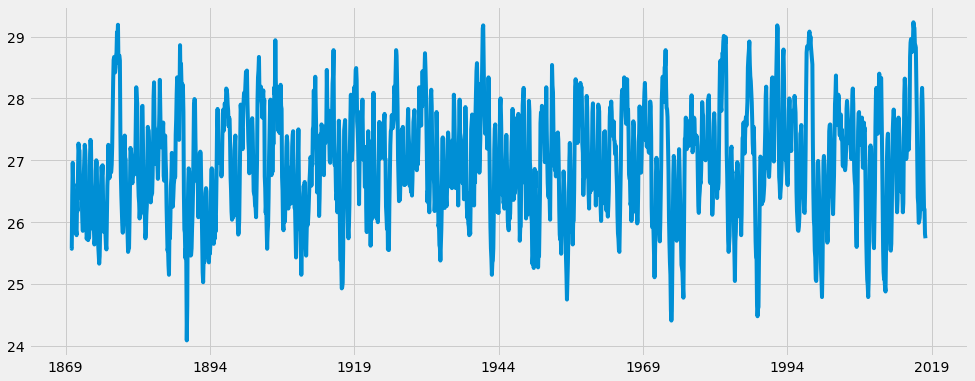

In [108]:
series = pd.Series.from_csv('../../data/oni/csv/nino34.csv')
print(series.describe())
series.plot(figsize=(15, 6))
plt.show()

In [109]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [110]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(series,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            print("error --> misspecifications")
            continue
            

error --> misspecifications
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:14309.775988983449
error --> misspecifications
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:4138.938442039848
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:5313.368899482111
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:4147.853056259412
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:4967.405638293304
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:4137.530669790479
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:14326.585399901509
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:11949.354705078866
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:3782.580553154105
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2617.2230747311023
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:3787.6937894427265
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:3813.40500708573
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:3422.9552198746806
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2615.6919184934854
error --> misspecifications
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1597.6189128740773
error --> misspecifications
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:807.3184864979158
A

In [111]:
mod = sm.tsa.statespace.SARIMAX(series,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6211      0.207      3.005      0.003       0.216       1.026
ma.L1         -0.5771      0.214     -2.697      0.007      -0.996      -0.158
ar.S.L12      -0.0686      0.023     -3.033      0.002      -0.113      -0.024
ma.S.L12      -0.9976      0.047    -21.166      0.000      -1.090      -0.905
sigma2         0.0890      0.005     19.636      0.000       0.080       0.098


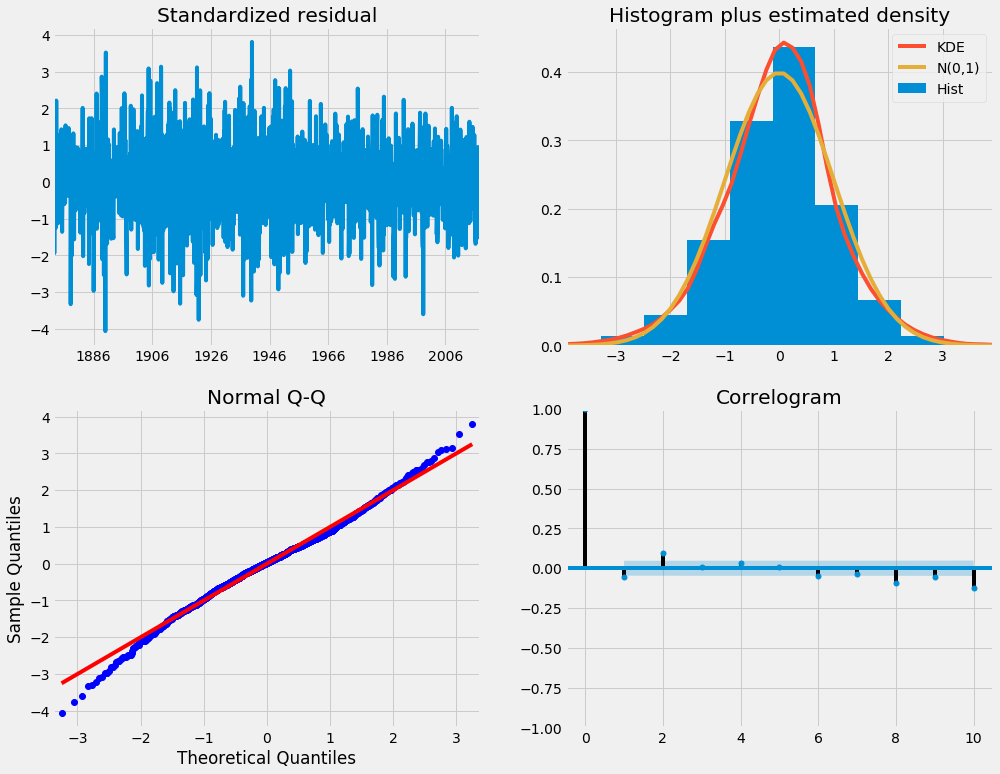

In [112]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [113]:
pred = results.get_prediction(start=pd.to_datetime('1988-01-01'), dynamic=False)
pred_ci = pred.conf_int()

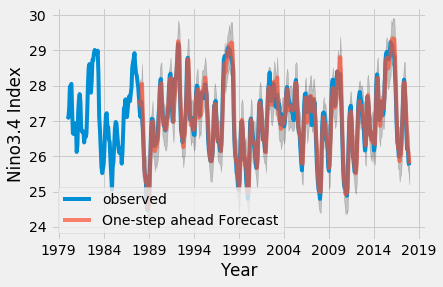

In [114]:
ax = series['1980':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Year')
ax.set_ylabel('Nino3.4 Index')
plt.legend()

plt.show()

In [115]:
# One-step ahead Forecast
y_forecasted = pred.predicted_mean
# print(y_forecasted)
y_truth = series['1988-01-01':]
# print(y_truth)

# Compute the mean square error
rmse = sqrt(((y_forecasted - y_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 3)))

The Root Mean Squared Error of our forecasts is 0.261


In [116]:
# Dynamic Forecast
pred_dynamic = results.get_prediction(start=pd.to_datetime('1988-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

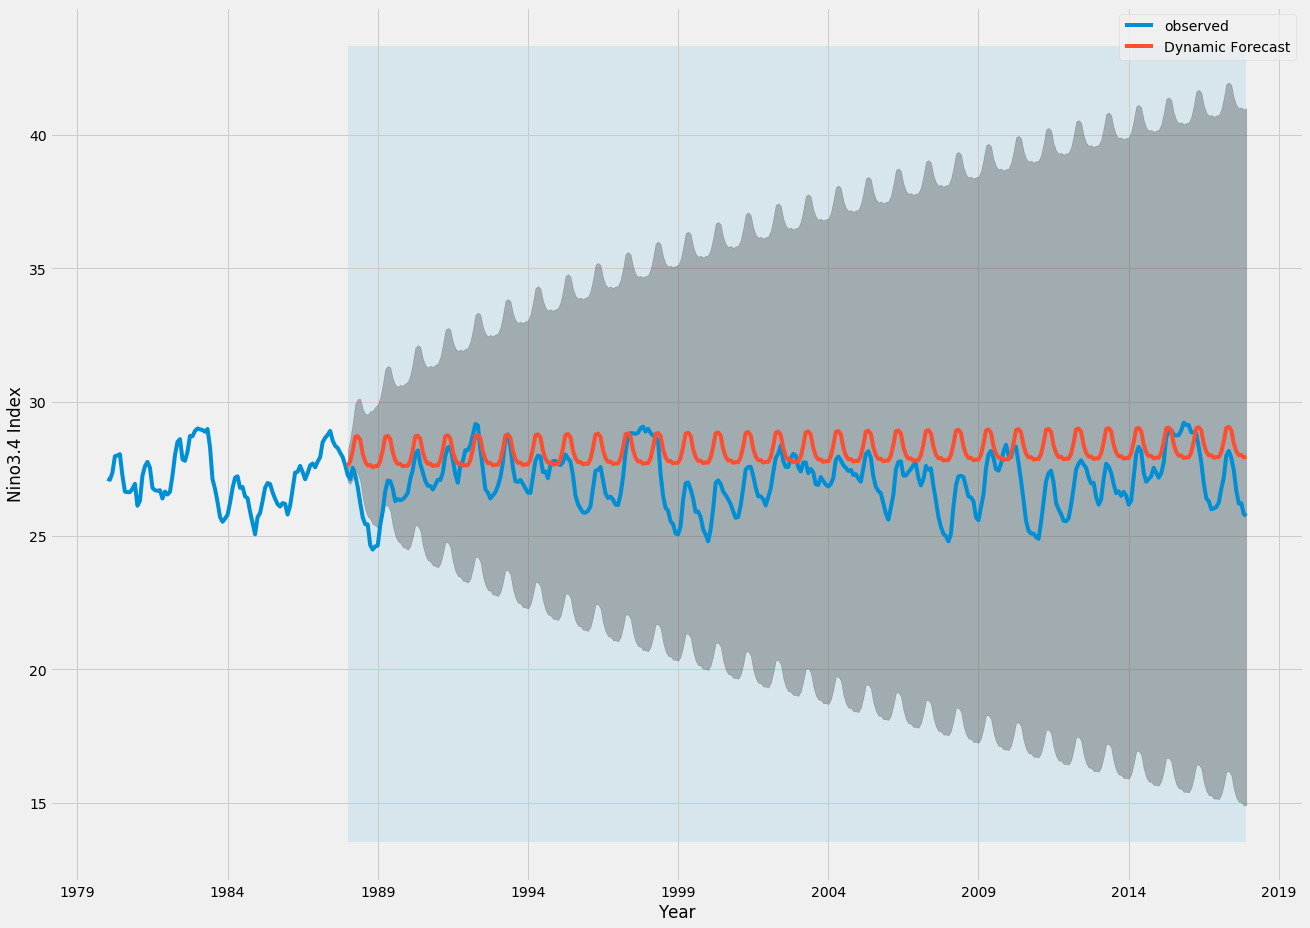

In [117]:
ax = series['1980':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1988-01-01'), series.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Year')
ax.set_ylabel('Nino3.4 Index')

plt.legend()
plt.show()

In [118]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = series['1988-01-01':]
# Compute the mean square error
rmse = sqrt(((y_forecasted - y_truth) ** 2).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 3)))

The Root Mean Squared Error of our forecasts is 1.426


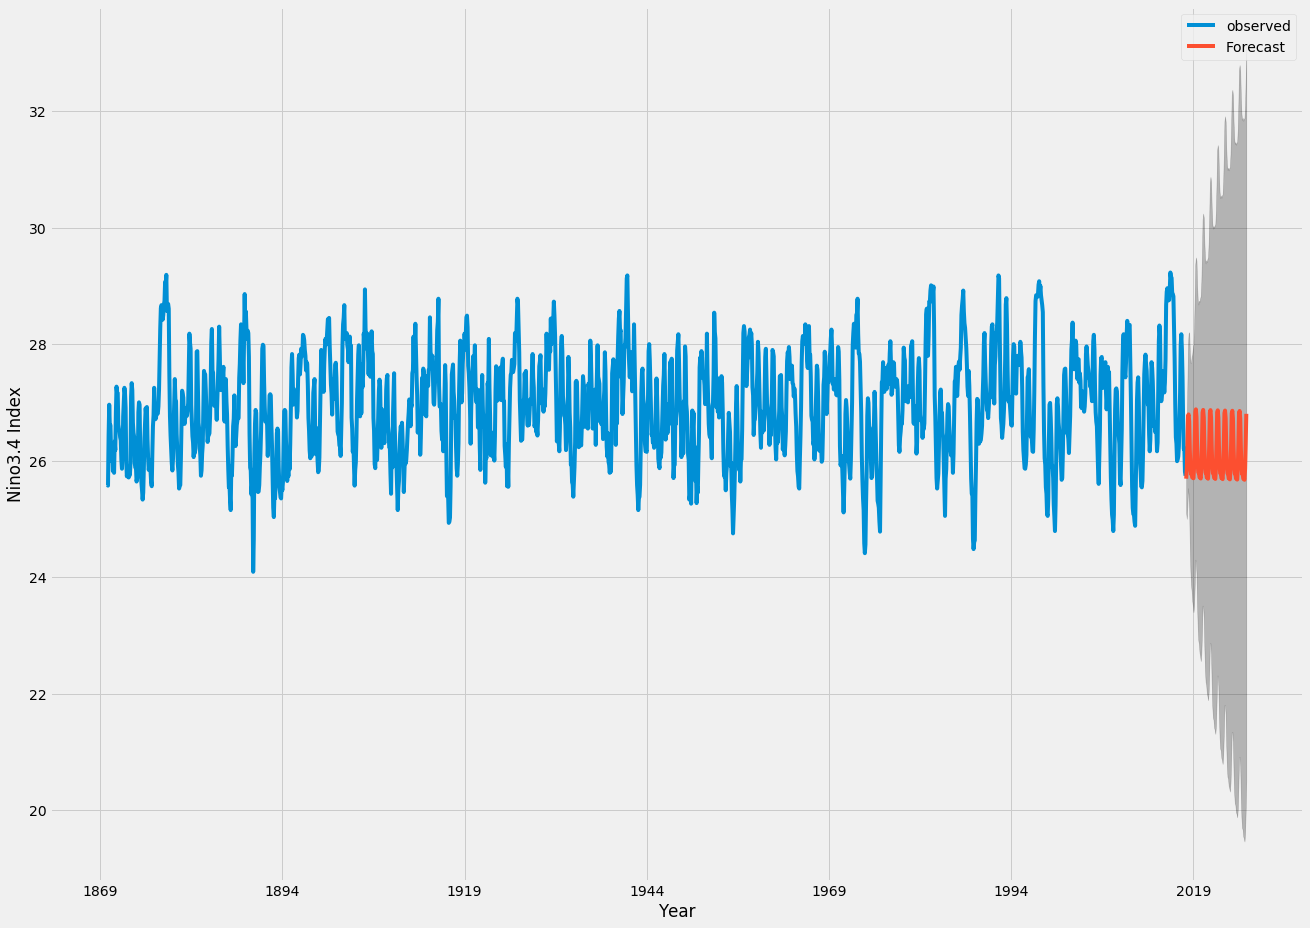

In [119]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()
ax = series.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('Nino3.4 Index')

plt.legend()
plt.show()